In [4]:
# A. Collecte des données

## 1. Source du Corpus
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Installation des dépendances NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DJIBINDIAYE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DJIBINDIAYE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DJIBINDIAYE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True


A. Collecte des données
    1. Source du Corpus Nous avons collecté notre corpus à partir du “Corpus politique de Twitter”, disponible à [insérer le lien]. Ce corpus fournit une diversité de tweets provenant de différentes sources politiques sur Twitter, ce qui en fait une ressource pertinente pour notre étude de classification.

In [5]:
import requests

class DataDownloader:
    def __init__(self, urls, local_filename):
        self.urls = urls
        self.local_filename = local_filename

    def download_data(self):
        # Télécharger les données depuis chaque URL
        data = []
        for url in self.urls:
            response = requests.get(url)
            if response.status_code == 200:
                # Ajouter les données à la liste
                data.append(response.text)
            else:
                print(f"Erreur lors du téléchargement depuis {url}")

        # Concaténer les données
        combined_data = "\n".join(data)

        # Enregistrer les données dans le fichier local
        with open(self.local_filename, 'w', encoding='utf-8') as file:
            file.write(combined_data)

        print(f"Données téléchargées et enregistrées dans {self.local_filename}")

# Utilisation des classes
url_keyword = "https://www.usna.edu/Users/cs/nchamber/data/twitter/keyword-tweets.txt"
url_general = "https://www.usna.edu/Users/cs/nchamber/data/twitter/general-tweets.txt"
local_filename = "combined_tweets.txt"

# Télécharger les données
print("------------ Télécharger les données ---------------")
downloader = DataDownloader(urls=[url_keyword, url_general], local_filename=local_filename)
downloader.download_data()


------------ Télécharger les données ---------------
Données téléchargées et enregistrées dans combined_tweets.txt


2.	Description des données (format, taille, etc.)

----------Explorer les données----------------
   Label                                               Text
0  POLIT  Global Voices Online Â» Alex Castro: A liberal...
1  POLIT  Do the Conservatives Have a Death Wish? http:/...
2    NOT  @MMFlint I've seen all of your movies and Capi...
3  POLIT  RT @AllianceAlert: * House Dems ask for civili...
4  POLIT  RT @AdamSmithInst Quote of the week: My politi...
----------Distribution des classes----------------
Distribution des classes :
 Label
NOT      2285
POLIT    1719
Name: count, dtype: int64
----------Répartition de la longueur des tweets----------------


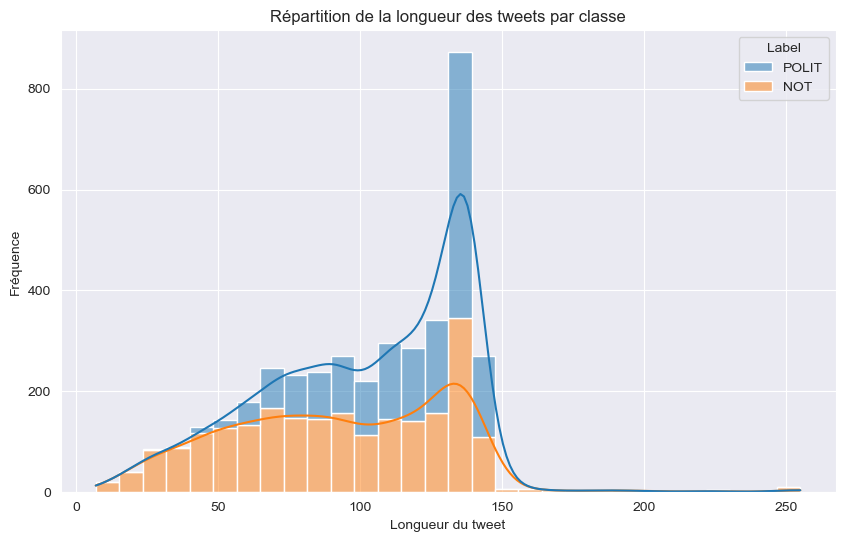

In [6]:
class DataExplorer:
    def __init__(self, filename):
        self.filename = filename
        self.df = None  # Ajoutez une variable pour stocker le DataFrame exploré

    def explore_data(self):
        # Charger les données dans un DataFrame
        self.df = pd.read_csv(self.filename, delimiter='\t', header=None, names=['Label', 'Text'])

        # Afficher les premières lignes du DataFrame pour comprendre la structure des données
        print(self.df.head())

        # Distribution des classes
        print("----------Distribution des classes----------------")
        class_distribution = self.df['Label'].value_counts()
        print("Distribution des classes :\n", class_distribution)

        # Longueur des tweets
        self.df['Tweet_Length'] = self.df['Text'].apply(len)

        # Répartition de la longueur des tweets
        print("----------Répartition de la longueur des tweets----------------")
        plt.figure(figsize=(10, 6))
        sns.histplot(self.df, x='Tweet_Length', hue='Label', bins=30, kde=True, multiple="stack")
        plt.title('Répartition de la longueur des tweets par classe')
        plt.xlabel('Longueur du tweet')
        plt.ylabel('Fréquence')
        plt.show()

    def get_explored_data(self):
        # Renvoie le DataFrame exploré
        return self.df

# Explorer les données
print("----------Explorer les données----------------")
explorer = DataExplorer(filename=local_filename)
explorer.explore_data()
explored_data = explorer.get_explored_data().copy()


3.	Traitements préliminaires (nettoyage, prétraitement)

In [10]:
class DataPreprocessor:
    def __init__(self, filename):
        self.filename = filename

    def preprocess_data(self):
        # Charger les données dans un DataFrame
        df = pd.read_csv(self.filename, delimiter='\t', header=None, names=['Label', 'Text'])

        # Nettoyage des tweets
        df['Cleaned_Text'] = df['Text'].apply(self.clean_tweet)

        # Tokenisation des tweets
        df['Tokenized_Text'] = df['Cleaned_Text'].apply(self.tokenize_text)

        # Réduction des mots à leur forme de base (utilisation de la lemmatisation)
        df['Lemmatized_Text'] = df['Tokenized_Text'].apply(self.lemmatize_text)

        return df[['Text', 'Label', 'Cleaned_Text', 'Tokenized_Text', 'Lemmatized_Text']]

    def clean_tweet(self, text):
        # Supprimer les mentions
        text = re.sub(r'@[A-Za-z0-9]+', '', text)
        # Supprimer les liens
        text = re.sub('https?://[A-Za-z0-9./]+', '', text)
        # Supprimer la ponctuation et les caractères spéciaux
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Convertir le texte en minuscules
        text = text.lower()
        return text

    def tokenize_text(self, text):
        # Tokenisation des tweets en mots
        tokens = word_tokenize(text)
        return tokens

    def lemmatize_text(self, tokens):
        # Réduction des mots à leur forme de base (utilisation de la lemmatisation)
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return lemmatized_tokens

# Télécharger les données nécessaires pour NLTK
nltk.download('punkt')
nltk.download('wordnet')

# Prétraitement des données
print("------------ Prétraitement des données ---------------")
preprocessor = DataPreprocessor(filename=local_filename)
preprocessed_data = preprocessor.preprocess_data()

# Afficher les premières lignes du DataFrame résultant
print(preprocessed_data.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DJIBINDIAYE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DJIBINDIAYE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


------------ Prétraitement des données ---------------
                                                Text  Label  \
0  Global Voices Online Â» Alex Castro: A liberal...  POLIT   
1  Do the Conservatives Have a Death Wish? http:/...  POLIT   
2  @MMFlint I've seen all of your movies and Capi...    NOT   
3  RT @AllianceAlert: * House Dems ask for civili...  POLIT   
4  RT @AdamSmithInst Quote of the week: My politi...  POLIT   

                                        Cleaned_Text  \
0  global voices online  alex castro a liberal li...   
1            do the conservatives have a death wish    
2   ive seen all of your movies and capitalism is...   
3  rt   house dems ask for civility at town halls...   
4  rt  quote of the week my political opinions le...   

                                      Tokenized_Text  \
0  [global, voices, online, alex, castro, a, libe...   
1     [do, the, conservatives, have, a, death, wish]   
2  [ive, seen, all, of, your, movies, and, capita...   
3  [r

B.	Représentation du texte
    1.	Utilisation TF-IDF pour la représentation numérique


In [11]:
# B. Représentation du texte

## 1. Utilisation TF-IDF pour la représentation numérique

class TextRepresentation:
    def __init__(self, df):
        self.df = df
        self.vectorizer = None  # Ajoutez cette ligne pour initialiser l'attribut vectorizer

    def tfidf_representation(self):
        # Séparation des données en ensembles d'entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(self.df['Lemmatized_Text'].apply(' '.join),
                                                            self.df['Label'], test_size=0.2, random_state=42)

        # Création d'un vecteur TF-IDF
        self.vectorizer = TfidfVectorizer()  # Vous pouvez ajuster le nombre maximal de fonctionnalités
        X_train_tfidf = self.vectorizer.fit_transform(X_train)
        X_test_tfidf = self.vectorizer.transform(X_test)

        return X_train_tfidf, X_test_tfidf, y_train, y_test


# Utilisation de la classe TextRepresentation
representation = TextRepresentation(df=preprocessed_data)
X_train_tfidf, X_test_tfidf, y_train, y_test = representation.tfidf_representation()


In [12]:
# Utilisation de la classe DataSplitter
class DataSplitter:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def split_data(self):
        # Division des données en ensembles d'entraînement, de validation et de test
        X_train, X_temp, y_train, y_temp = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        return X_train, X_val, X_test, y_train, y_val, y_test


# Utilisation de la classe DataSplitter
splitter = DataSplitter(X=X_train_tfidf, y=y_train)
X_train, X_val, X_test, y_train, y_val, y_test = splitter.split_data()

# Afficher la forme des ensembles
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

# Création d'un DataFrame pour l'ensemble d'entraînement
train_df = pd.DataFrame(X_train.toarray(), columns=representation.vectorizer.get_feature_names_out())
train_df['Label'] = y_train

# Afficher les premières lignes du DataFrame d'entraînement
print("DataFrame d'entraînement:")
print(train_df.head())

# Création d'un DataFrame pour l'ensemble de test
test_df = pd.DataFrame(X_test.toarray(), columns=representation.vectorizer.get_feature_names_out())
test_df['Label'] = y_test

# Afficher les premières lignes du DataFrame de test
print("\nDataFrame de test:")
print(test_df.head())


Shape of X_train: (2562, 9591)
Shape of X_val: (320, 9591)
Shape of X_test: (321, 9591)
DataFrame d'entraînement:
   aaaaaaaaaaaaaaaaaaaaaah  aaaaaahhhhhhh  aaaah  aagghh  aahh  aan  aarp  \
0                      0.0            0.0    0.0     0.0   0.0  0.0   0.0   
1                      0.0            0.0    0.0     0.0   0.0  0.0   0.0   
2                      0.0            0.0    0.0     0.0   0.0  0.0   0.0   
3                      0.0            0.0    0.0     0.0   0.0  0.0   0.0   
4                      0.0            0.0    0.0     0.0   0.0  0.0   0.0   

    ab  abandoned  abba  ...  zombieland  zombifiedhalloween  zona  zone  zoo  \
0  0.0        0.0   0.0  ...         0.0                 0.0   0.0   0.0  0.0   
1  0.0        0.0   0.0  ...         0.0                 0.0   0.0   0.0  0.0   
2  0.0        0.0   0.0  ...         0.0                 0.0   0.0   0.0  0.0   
3  0.0        0.0   0.0  ...         0.0                 0.0   0.0   0.0  0.0   
4  0.0        0.0 

C.	Modélisation
    1.	Sélection du modèle de classification (Naive Bayes)


best_classifier : MultinomialNB(alpha=0.5)
Meilleure valeur d'alpha : 0.5
Précision sur l'ensemble de test: 0.8318

Rapport de classification sur l'ensemble de test:

              precision    recall  f1-score   support

         NOT       0.83      0.87      0.85       175
       POLIT       0.84      0.78      0.81       146

    accuracy                           0.83       321
   macro avg       0.83      0.83      0.83       321
weighted avg       0.83      0.83      0.83       321

Matrice de confusion sur l'ensemble de test:

[[153  22]
 [ 32 114]]


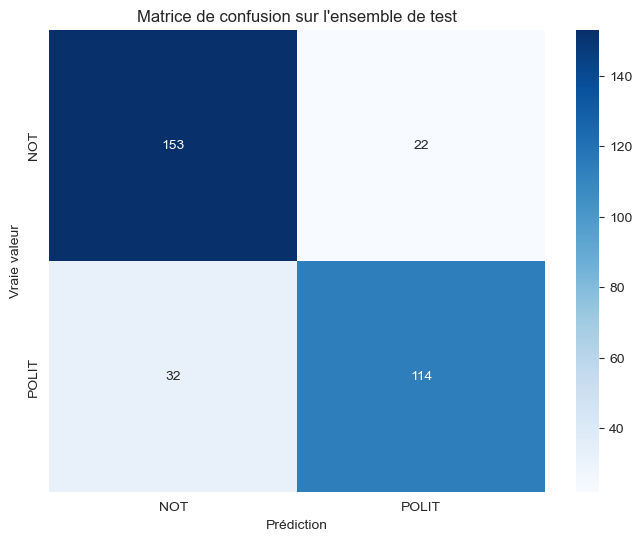

Classification du tweet : NOT


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt

class TextClassifier:
    def __init__(self, X_train, X_validation, X_test, y_train, y_validation, y_test, vectorizer):
        self.X_train = X_train
        self.X_validation = X_validation
        self.X_test = X_test
        self.y_train = y_train
        self.y_validation = y_validation
        self.y_test = y_test
        self.classifier = None
        self.preprocessor = preprocessor
        self.vectorizer = vectorizer  # Utilisez le vectorizer fourni en argument

    def train_classifier(self, X, y):
        # Définir les valeurs d'alpha que vous souhaitez essayer
        alphas = [0.1, 0.5, 1.0, 1.5, 2.0]

        # Créer une grille de recherche
        param_grid = {'alpha': alphas}
        grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')

        # Exécuter la recherche par grille sur les données d'entraînement
        grid_search.fit(X, y)

        # Obtenir le meilleur modèle après la recherche par grille
        best_classifier = grid_search.best_estimator_

        # Entraîner le modèle sur l'ensemble complet d'entraînement avec la meilleure valeur d'alpha
        best_classifier.fit(X, y)

        # Enregistrer le meilleur classificateur dans votre classe pour une utilisation ultérieure
        self.classifier = best_classifier
        print("best_classifier :", best_classifier)

        # Afficher la meilleure valeur d'alpha
        print(f"Meilleure valeur d'alpha : {grid_search.best_params_['alpha']}")

    def evaluate_classifier(self, X, y, set_name):
        if self.classifier is None:
            raise ValueError("Le classificateur n'a pas été entraîné. Utilisez train_classifier avant l'évaluation.")

        # Prédire les labels sur les données
        y_pred = self.classifier.predict(X)

        # Évaluer la performance du modèle
        accuracy = accuracy_score(y, y_pred)
        print(f"Précision sur l'ensemble {set_name}: {accuracy:.4f}\n")

        # Afficher le rapport de classification
        print(f"Rapport de classification sur l'ensemble {set_name}:\n")
        print(classification_report(y, y_pred))

        # Afficher la matrice de confusion
        print(f"Matrice de confusion sur l'ensemble {set_name}:\n")
        print(confusion_matrix(y, y_pred))

        # Visualiser la matrice de confusion avec seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y)),
                    yticklabels=sorted(set(y)))
        plt.title(f"Matrice de confusion sur l'ensemble {set_name}")
        plt.xlabel('Prédiction')
        plt.ylabel('Vraie valeur')
        plt.show()

    def grid_search(self, param_grid):
        if self.X_train is None or self.y_train is None:
            raise ValueError("Les données d'entraînement ne sont pas définies.")

        # Initialiser un classificateur Naive Bayes
        classifier = MultinomialNB()

        # Utiliser la recherche par grille pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', verbose=1)
        grid_search.fit(self.X_train, self.y_train)

        # Afficher les meilleurs hyperparamètres
        print("Meilleurs hyperparamètres trouvés par la recherche par grille:")
        print(grid_search.best_params_)

        # Utiliser les meilleurs hyperparamètres pour entraîner le modèle
        best_classifier = grid_search.best_estimator_

        self.classifier = best_classifier

        return best_classifier


    def classify(self, tweet):
        if self.classifier is None:
            raise ValueError("Le classificateur n'a pas été entraîné. Utilisez train_classifier avant la classification.")

        # Utilisez le modèle pour classer le tweet
        tweet = self.preprocessor.clean_tweet(tweet)
        tweet = self.preprocessor.tokenize_text(tweet)
        tweet = self.preprocessor.lemmatize_text(tweet)
        preprocessed_tweet = ' '.join(tweet)
        preprocessed_tweet = str(preprocessed_tweet).lower()

        tweet_tfidf = self.vectorizer.transform([preprocessed_tweet])
        prediction = self.classifier.predict(tweet_tfidf)

        # Retournez le résultat de la classification
        return prediction[0]


# Utilisation de la classe TextClassifier pour entraîner le modèle
classifier = TextClassifier(X_train_tfidf, X_val, X_test_tfidf, y_train, y_val, y_test, representation.vectorizer)
classifier.train_classifier(X_train, y_train)

# Évaluer le classificateur sur l'ensemble de test
classifier.evaluate_classifier(X_test, y_test, "de test")

# Classer un tweet
tweet = "And he doesn't even get paid to be funny: RT @QueenofSpain SC GOP'r likens Michelle Obama to escaped gorilla. http://tinyurl.com/kogvbc"
classification_result = classifier.classify(tweet)

print(f"Classification du tweet : {classification_result}")


Amelioration de la re representation

best_classifier : MultinomialNB(alpha=0.5)
Meilleure valeur d'alpha : 0.5
Précision sur l'ensemble de test: 0.8318

Rapport de classification sur l'ensemble de test:

              precision    recall  f1-score   support

         NOT       0.83      0.87      0.85       175
       POLIT       0.84      0.78      0.81       146

    accuracy                           0.83       321
   macro avg       0.83      0.83      0.83       321
weighted avg       0.83      0.83      0.83       321

Matrice de confusion sur l'ensemble de test:

[[153  22]
 [ 32 114]]


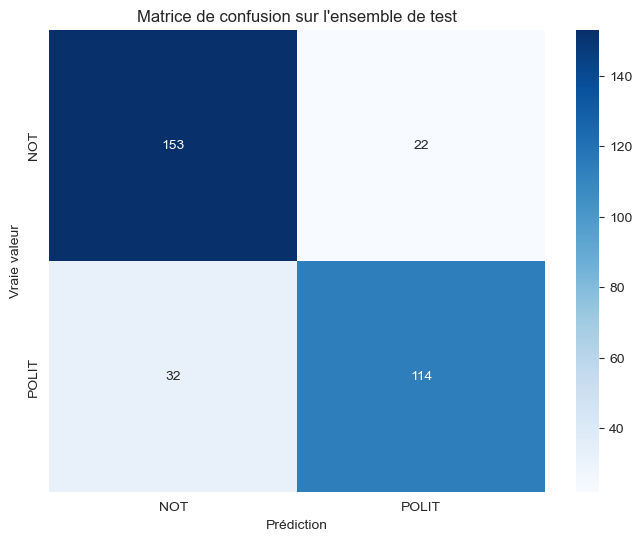

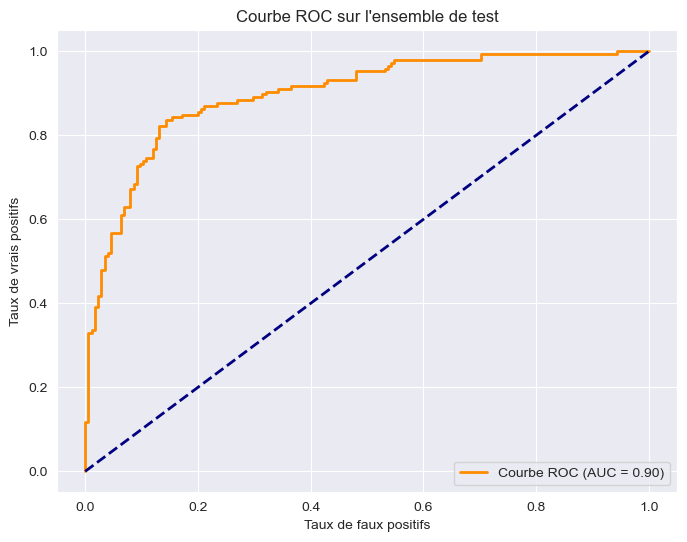

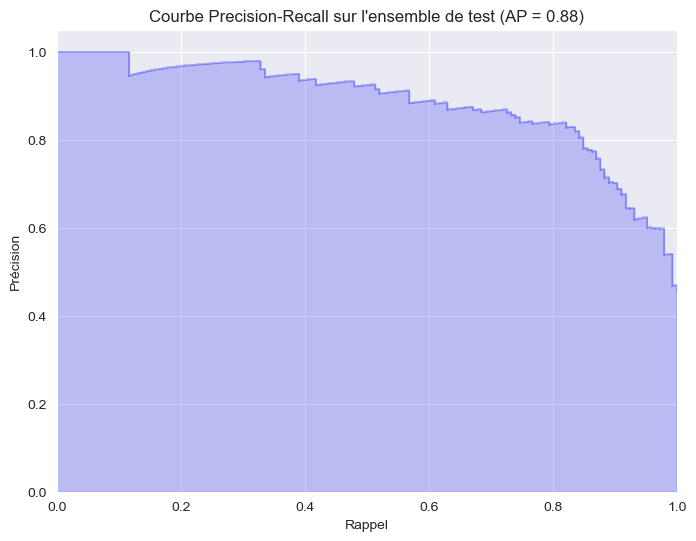

Classification du tweet : POLIT


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from pretraitement_donnees.pretraitement import *

class TextClassifier:
    def __init__(self, X_train, X_validation, X_test, y_train, y_validation, y_test, vectorizer):
        self.X_train = X_train
        self.X_validation = X_validation
        self.X_test = X_test
        self.y_train = y_train
        self.y_validation = y_validation
        self.y_test = y_test
        self.classifier = None
        self.preprocessor = preprocessor
        self.vectorizer = vectorizer  # Utilisez le vectorizer fourni en argument

    def train_classifier(self, X, y):
        # Définir les valeurs d'alpha que vous souhaitez essayer
        alphas = [0.1, 0.5, 1.0, 1.5, 2.0]

        # Créer une grille de recherche
        param_grid = {'alpha': alphas}
        grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')

        # Exécuter la recherche par grille sur les données d'entraînement
        grid_search.fit(X, y)

        # Obtenir le meilleur modèle après la recherche par grille
        best_classifier = grid_search.best_estimator_

        # Entraîner le modèle sur l'ensemble complet d'entraînement avec la meilleure valeur d'alpha
        best_classifier.fit(X, y)

        # Enregistrer le meilleur classificateur dans votre classe pour une utilisation ultérieure
        self.classifier = best_classifier
        print("best_classifier :", best_classifier)

        # Afficher la meilleure valeur d'alpha
        print(f"Meilleure valeur d'alpha : {grid_search.best_params_['alpha']}")

    def evaluate_classifier(self, X, y, set_name):
        if self.classifier is None:
            raise ValueError("Le classificateur n'a pas été entraîné. Utilisez train_classifier avant l'évaluation.")

        # Convertir les labels 'NOT' et 'POLIT' en 0 et 1
        y_binary = y.map({'NOT': 0, 'POLIT': 1})

        # Prédire les labels sur les données
        y_pred = self.classifier.predict(X)
        y_prob = self.classifier.predict_proba(X)[:, 1]

        # Afficher la courbe ROC
        fpr, tpr, _ = roc_curve(y_binary, y_prob, pos_label=1)  # Spécifier pos_label ici
        roc_auc = auc(fpr, tpr)

        # Évaluer la performance du modèle
        accuracy = accuracy_score(y, y_pred)
        print(f"Précision sur l'ensemble {set_name}: {accuracy:.4f}\n")

        # Afficher le rapport de classification
        print(f"Rapport de classification sur l'ensemble {set_name}:\n")
        print(classification_report(y, y_pred))

        # Afficher la matrice de confusion
        print(f"Matrice de confusion sur l'ensemble {set_name}:\n")
        print(confusion_matrix(y, y_pred))

        # Visualiser la matrice de confusion avec seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(y)),
                    yticklabels=sorted(set(y)))
        plt.title(f"Matrice de confusion sur l'ensemble {set_name}")
        plt.xlabel('Prédiction')
        plt.ylabel('Vraie valeur')
        plt.show()

        # Afficher la courbe ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title(f'Courbe ROC sur l\'ensemble {set_name}')
        plt.legend(loc="lower right")
        plt.show()

        # Afficher la courbe Precision-Recall
        precision, recall, _ = precision_recall_curve(y_binary, y_prob)
        average_precision = average_precision_score(y_binary, y_prob)

        plt.figure(figsize=(8, 6))
        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlabel('Rappel')
        plt.ylabel('Précision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(f'Courbe Precision-Recall sur l\'ensemble {set_name} (AP = {average_precision:.2f})')
        plt.show()

    def grid_search(self, param_grid):
        if self.X_train is None or self.y_train is None:
            raise ValueError("Les données d'entraînement ne sont pas définies.")

        # Initialiser un classificateur Naive Bayes
        classifier = MultinomialNB()

        # Utiliser la recherche par grille pour trouver les meilleurs hyperparamètres
        grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', verbose=1)
        grid_search.fit(self.X_train, self.y_train)

        # Afficher les meilleurs hyperparamètres
        print("Meilleurs hyperparamètres trouvés par la recherche par grille:")
        print(grid_search.best_params_)

        # Utiliser les meilleurs hyperparamètres pour entraîner le modèle
        best_classifier = grid_search.best_estimator_

        self.classifier = best_classifier

        return best_classifier


    def classify(self, tweet):
        if self.classifier is None:
            raise ValueError("Le classificateur n'a pas été entraîné. Utilisez train_classifier avant la classification.")

        # Utilisez le modèle pour classer le tweet
        tweet = self.preprocessor.clean_tweet(tweet)
        tweet = self.preprocessor.tokenize_text(tweet)
        tweet = self.preprocessor.lemmatize_text(tweet)
        preprocessed_tweet = ' '.join(tweet)
        preprocessed_tweet = str(preprocessed_tweet).lower()

        tweet_tfidf = self.vectorizer.transform([preprocessed_tweet])
        prediction = self.classifier.predict(tweet_tfidf)

        # Retournez le résultat de la classification
        return prediction[0]


# Utilisation de la classe TextClassifier pour entraîner le modèle
classifier = TextClassifier(X_train_tfidf, X_val, X_test_tfidf, y_train, y_val, y_test, representation.vectorizer)
classifier.train_classifier(X_train, y_train)

# Évaluer le classificateur sur l'ensemble de test
classifier.evaluate_classifier(X_test, y_test, "de test")

# Classer un tweet
tweet = "Another Liberal from Massachusetts Attacks Palin and Proves That He Doesnâ€™t Know What Heâ€™s Talking About http://bit.ly/1apDVO"
classification_result = classifier.classify(tweet)

print(f"Classification du tweet : {classification_result}")

